In [1]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

import shap

In [2]:
# 获取当前目录
current_dir = os.getcwd()

file_list = []
# 遍历当前目录及其子目录
for root, dirs, files in os.walk(current_dir):
    for file in files:
        if file.endswith(".mat"):
           file_list.append(file)

In [3]:
file_list.sort()

In [4]:
L_fix = [0.03, 1]
D_fix = [4, 0.03]
R_fix = [4, 1]

In [5]:
L_change = [1, 1.3, 1.8, 2.3, 2.8, 3.3, 3.8, 4.3, 4.8]
D_change = [0.5, 0.8, 1.3, 1.8, 2.3]
R_change = [0.005, 0.02, 0.045, 0.07, 0.095]

In [6]:
angle = np.linspace(0, 180, 91)

In [7]:
L_param = np.array([[item] + L_fix for item in [item for item in L_change for _ in range(2)]])
D_param = np.array([D_fix + [item] for item in [item for item in D_change for _ in range(2)]])
R_param = np.array([[R_fix[0]]+[item]+[R_fix[1]] for item in [item for item in R_change for _ in range(2)]])

L_param = np.vstack([L_param, L_param, L_param])
D_param = np.vstack([D_param, D_param, D_param])
R_param = np.vstack([R_param, R_param, R_param])

print(L_param.shape, D_param.shape, R_param.shape)

(54, 3) (30, 3) (30, 3)


In [8]:
# 要复制的份数
k = len(angle)


# 初始化结果列表
L_arr = []

# 遍历原数组中的每一行
for row in L_param:
    # 遍历每一个要添加的元素
    for element in angle:
        # 将原行与新元素结合，并添加到结果中
        new_row = np.append(row, element)
        L_arr.append(new_row)

L_arr = np.array(L_arr)

# 初始化结果列表
D_arr = []

# 遍历原数组中的每一行
for row in D_param:
    # 遍历每一个要添加的元素
    for element in angle:
        # 将原行与新元素结合，并添加到结果中
        new_row = np.append(row, element)
        D_arr.append(new_row)

D_arr = np.array(D_arr)

# 初始化结果列表
R_arr = []

# 遍历原数组中的每一行
for row in R_param:
    # 遍历每一个要添加的元素
    for element in angle:
        # 将原行与新元素结合，并添加到结果中
        new_row = np.append(row, element)
        R_arr.append(new_row)

R_arr = np.array(R_arr)

In [9]:
print(L_arr.shape, D_arr.shape, R_arr.shape)

(4914, 4) (2730, 4) (2730, 4)


In [10]:
L_arr[:5]

array([[1.  , 0.03, 1.  , 0.  ],
       [1.  , 0.03, 1.  , 2.  ],
       [1.  , 0.03, 1.  , 4.  ],
       [1.  , 0.03, 1.  , 6.  ],
       [1.  , 0.03, 1.  , 8.  ]])

In [11]:
channel_list = ['C']*182 + ['S']*182 + ['X']*182
channel_list = channel_list * 19
len(channel_list)

10374

In [12]:
polar_list = ['hh']*91 + ['vv']*91 
polar_list = polar_list * 57
len(polar_list)

10374

In [13]:
encoder = OneHotEncoder()
encoded_cats = encoder.fit_transform(np.hstack([np.array([channel_list]).reshape(-1, 1), np.array([polar_list]).reshape(-1, 1)]))
encoded_cats = encoded_cats.toarray()

In [14]:
nonclass_feature = np.vstack([D_arr, L_arr, R_arr])
nonclass_feature.shape

(10374, 4)

In [15]:
nonclass_feature = np.vstack([D_arr, L_arr, R_arr])
nonclass_feature.shape

(10374, 4)

In [19]:
X_feature = np.hstack([nonclass_feature, encoded_cats])

In [20]:
y_list_max, y_list_min, y_list_50, y_list_20, y_list_80 = [], [], [], [], []

for file in file_list:
    data = scipy.io.loadmat(file)
    max_data = data['fea_jing'][0][0][0][0][0][3].reshape(-1,)
    min_data = data['fea_jing'][0][0][0][0][0][4].reshape(-1,)
    percentile_50_data = data['fea_jing'][0][0][0][0][0][7].reshape(-1,)
    percentile_20_data = data['fea_jing'][0][0][0][0][0][-4].reshape(-1,)
    percentile_80_data = data['fea_jing'][0][0][0][0][0][-3].reshape(-1,)
    y_list_max.append(max_data)
    y_list_min.append(min_data)
    y_list_50.append(percentile_50_data)
    y_list_20.append(percentile_20_data)
    y_list_80.append(percentile_80_data)

total_y_max = np.array(y_list_max).reshape(114*91, 1)
total_y_min = np.array(y_list_min).reshape(114*91, 1)
total_y_50 = np.array(y_list_50).reshape(114*91, 1)
total_y_20 = np.array(y_list_20).reshape(114*91, 1)
total_y_80 = np.array(y_list_80).reshape(114*91, 1)

total_y = np.hstack((total_y_max, total_y_min, total_y_50, total_y_20, total_y_80))

In [21]:
y_feature = total_y

In [22]:
# 分割数据集
# X_train, X_test, y_train, y_test = train_test_split(X_feature, y_feature, test_size=0.2, random_state=42)

# X_train = X_feature[:90*91]
# X_test = X_feature[90*91:]
# y_train = y_feature[:90*91]
# y_test = y_feature[90*91:]

X_train = X_feature[:108*91]
X_test = X_feature[108*91:]
y_train = y_feature[:108*91]
y_test = y_feature[108*91:]

In [23]:
X_train.shape, y_train.shape

((9828, 9), (9828, 5))

In [24]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# class RegressionModel(nn.Module):
#     def __init__(self, input_dim):
#         super(RegressionModel, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 64)
#         self.fc2 = nn.Linear(64, 32)
#         self.fc3 = nn.Linear(32, 1)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         x = self.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# 创建模型实例
input_dim = X_train.shape[1]
output_dim = y_feature.shape[1]
model = RegressionModel(input_dim, output_dim)

In [25]:
a = torch.randn(32, X_train.shape[1])

In [26]:
b = model(a)

In [27]:
b.shape

torch.Size([32, 5])

In [28]:
class QuantileLoss(nn.Module):
    def __init__(self, quantile):
        super(QuantileLoss, self).__init__()
        self.quantile = quantile

    def forward(self, y_pred, y_true):
        errors = y_true - y_pred
        loss = torch.max((self.quantile - 1) * errors, self.quantile * errors)
        return torch.mean(loss)

In [29]:
# 将数据转换为PyTorch张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# 创建数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 定义损失函数和优化器
quantiles = [1, 0, 0.5, 0.2, 0.8]
criterion_100 = QuantileLoss(quantile=0.99)
criterion_0 = QuantileLoss(quantile=0.01)
criterion_50 = QuantileLoss(quantile=0.5)
criterion_20 = QuantileLoss(quantile=0.2)
criterion_80 = QuantileLoss(quantile=0.8)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 400
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        # 前向传播
        outputs = model(X_batch)
        loss_100 = criterion_100(outputs[:, 0], y_batch[:, 0])
        loss_0 = criterion_0(outputs[:, 1], y_batch[:, 1])
        loss_50 = criterion_50(outputs[:, 2], y_batch[:, 2])
        loss_20 = criterion_20(outputs[:, 3], y_batch[:, 3])
        loss_80 = criterion_80(outputs[:, 4], y_batch[:, 4])

        # 总损失为三者之和
        total_loss = loss_100 + loss_80 + loss_50 + loss_20 + loss_0
        # total_loss = loss_100 
        
        # 反向传播和优化
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss.item():.4f}')

Epoch [10/400], Loss: 10.1071
Epoch [20/400], Loss: 7.5245
Epoch [30/400], Loss: 8.6964
Epoch [40/400], Loss: 5.0862
Epoch [50/400], Loss: 7.1821
Epoch [60/400], Loss: 6.1624
Epoch [70/400], Loss: 4.3507
Epoch [80/400], Loss: 5.5386
Epoch [90/400], Loss: 6.0307
Epoch [100/400], Loss: 4.1182
Epoch [110/400], Loss: 5.0742
Epoch [120/400], Loss: 4.7846
Epoch [130/400], Loss: 3.0541
Epoch [140/400], Loss: 5.1000
Epoch [150/400], Loss: 4.4039
Epoch [160/400], Loss: 2.7661
Epoch [170/400], Loss: 6.7407
Epoch [180/400], Loss: 5.1582
Epoch [190/400], Loss: 3.3565
Epoch [200/400], Loss: 4.3701
Epoch [210/400], Loss: 2.8338
Epoch [220/400], Loss: 4.2657
Epoch [230/400], Loss: 2.2622
Epoch [240/400], Loss: 2.7771
Epoch [250/400], Loss: 4.1079
Epoch [260/400], Loss: 5.2392
Epoch [270/400], Loss: 3.5712
Epoch [280/400], Loss: 4.7805
Epoch [290/400], Loss: 2.4333
Epoch [300/400], Loss: 3.8938
Epoch [310/400], Loss: 3.6924
Epoch [320/400], Loss: 3.2486
Epoch [330/400], Loss: 4.3021
Epoch [340/400], L

In [30]:
torch.save(model.state_dict(), 'qr.pth')
# 模型评估
# model.eval()
# with torch.no_grad():
#     predictions = model(X_test_tensor)
#     test_loss = criterion(predictions, y_test_tensor)
#     print(f'Test Loss: {test_loss.item():.4f}')

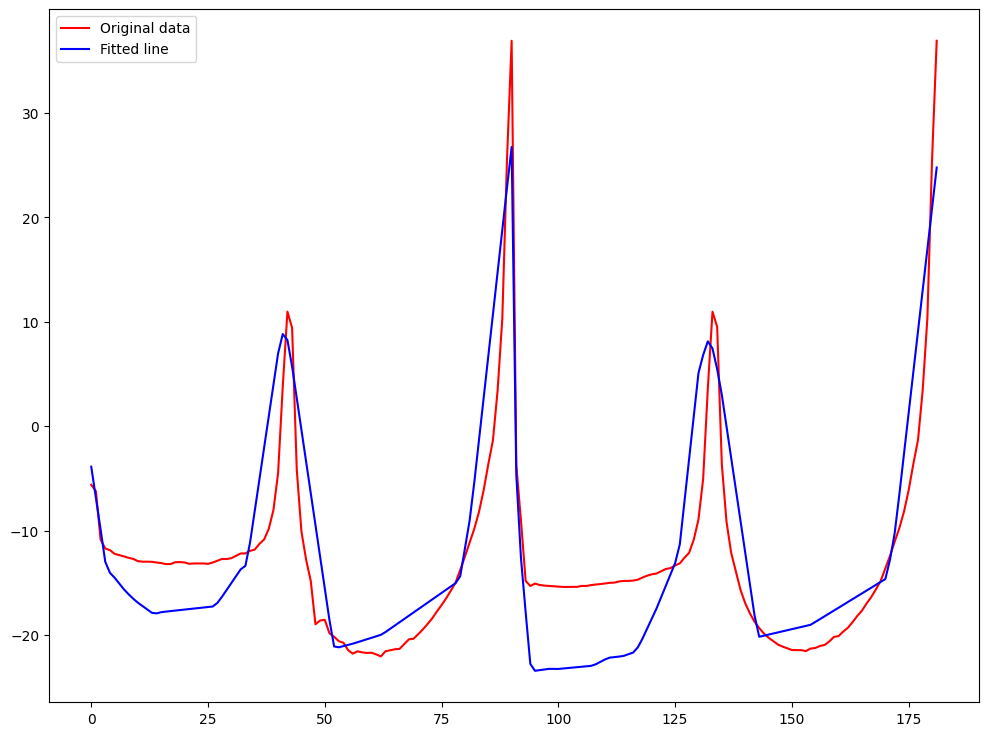

In [35]:
predict_first = model(torch.tensor(X_feature, dtype=torch.float32))[-182:][:, 4].detach().numpy()
# predict_first = (model(torch.tensor(X_feature, dtype=torch.float32))[-182:][:, 3].detach().numpy() + model(torch.tensor(X_feature, dtype=torch.float32))[-182:][:, 4].detach().numpy()) / 2
first = y_feature[-182:][:, 4]

# predict_first = model(torch.tensor(X_feature, dtype=torch.float32)[-1092:-546]).detach().numpy().reshape(-1,)
# first = y_feature[-1092:-546]

plt.figure(figsize=(12, 9))
# 可视化结果
plt.plot(first, 'r-', label='Original data')
plt.plot(predict_first, 'b-', label='Fitted line')
plt.legend()
plt.show()

In [ ]:
y_feature[-182:][:, 0].shape

In [ ]:
model(torch.tensor(X_feature, dtype=torch.float32))[-182:][:, 0].detach().numpy().shape

In [ ]:
y_feature[-182:][:, 4]

In [ ]:
plt.plot(model(torch.tensor(X_feature, dtype=torch.float32))[-182:][:, 4].detach().numpy())

In [ ]:
model(torch.tensor(X_feature, dtype=torch.float32))[-182:][:, 4].detach().numpy()